In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pbdlib as pbd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from pbdlib.utils.jupyter_utils import *
np.set_printoptions(precision=2)

## Gaussian Mixture Model (GMM)

Analysis of the basics notebook


Now to check with data created from demonstrations

In [69]:
dp = os.path.dirname(pbd.__file__) + '/data/demos/corrected'
filelist = next(os.walk(dp))[2]
filelist_short = filelist[0:3]
data = []
for f in filelist_short:
    temp = np.genfromtxt(dp + '/' + f, delimiter=',')
    data.append(temp[:,[0, 1, 5]])

In [70]:
print(filelist_short)

['trial_024_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_113_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_085_slash_relaxed_ik_slash_ee_pose_goals.csv']


In [71]:
t = np.linspace(0, 100, data[0].shape[0])

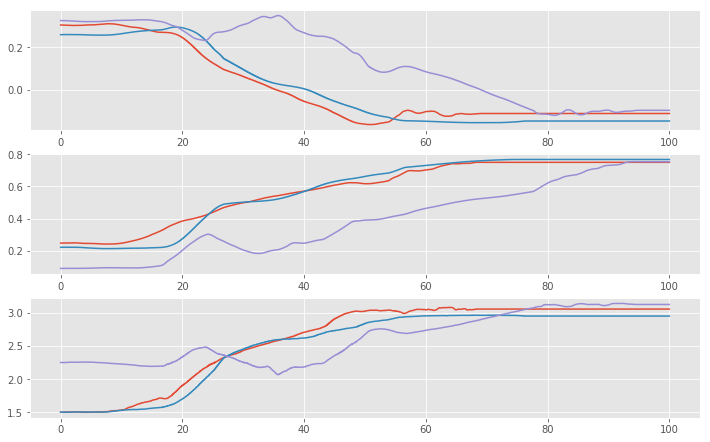

In [72]:
# plotting
fig, ax = plt.subplots(nrows=3)
fig.set_size_inches(12,7.5)
for i in range(3):
    for p in data:
        ax[i].plot(t, p[:, i])

In [78]:
# Fix for start and end frame
data_start = []
data_end = []
def equalizer(a):
    x0 = a[0] - equal[0]
    y0 = a[1] - equal[1]
    
    x = np.cos(equal[2])*x0 + np.sin(equal[2])*y0
    y = - np.sin(equal[2])*x0 + np.cos(equal[2])*y0
    
    yaw = a[2] - equal[2]
    return [x, y, yaw]

for p in data:
    # Set start point
    equal = p[0,:]
    xyyaw = np.apply_along_axis(equalizer, 1, p)
    data_start.append(xyyaw)

for p in data:
    # Set start point
    equal = p[-1,:]
    xyyaw = np.apply_along_axis(equalizer, 1, p)
    data_end.append(xyyaw)

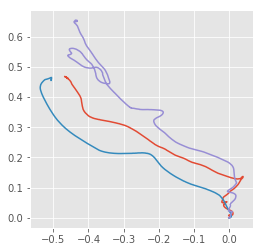

In [79]:
plt.figure(figsize=(4,4))
for p in data_end:
    plt.plot(p[:, 0], p[:, 1])

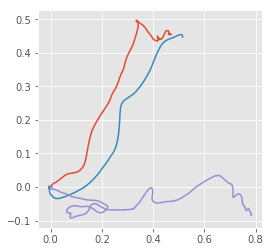

In [80]:
plt.figure(figsize=(4,4))
for p in data_start:
    plt.plot(p[:, 0], p[:, 1])

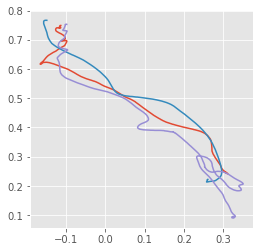

In [77]:
plt.figure(figsize=(4,4))
for p in data:
    plt.plot(p[:, 0], p[:, 1])

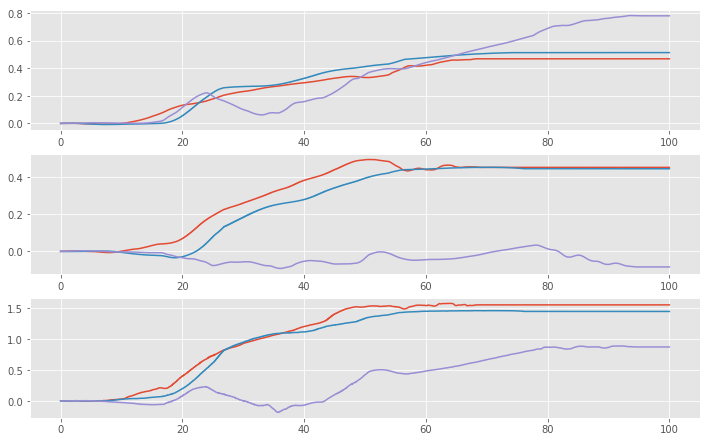

In [81]:
# plotting
fig, ax = plt.subplots(nrows=3)
fig.set_size_inches(12,7.5)
for i in range(3):
    for p in data_start:
        ax[i].plot(t, p[:, i])

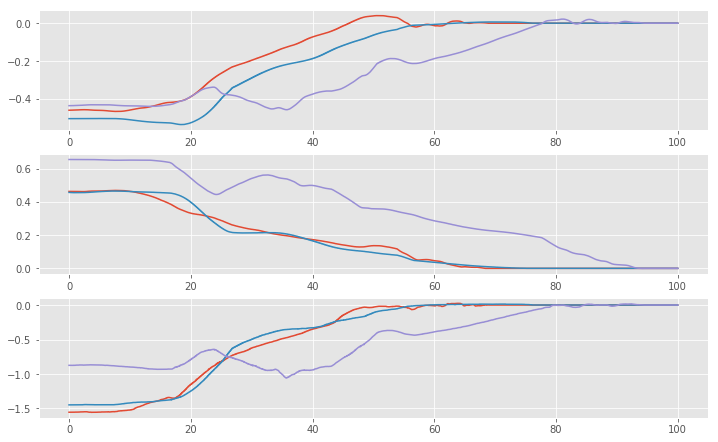

In [82]:
# plotting
fig, ax = plt.subplots(nrows=3)
fig.set_size_inches(12,7.5)
for i in range(3):
    for p in data_end:
        ax[i].plot(t, p[:, i])

This cell runs the GMM with the start and end frame

In [86]:
demos = [np.hstack([s, e]) for e in data_end for s in data_start]

model = pbd.HMM(nb_dim=6, nb_states=5)

model.init_hmm_kbins(demos)

model.em(demos, reg=1e-3)

EM did not converge


False

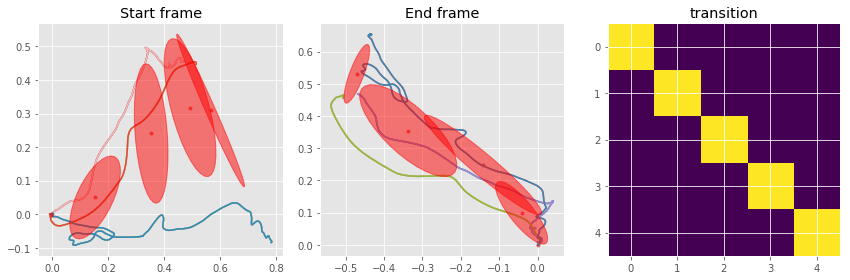

In [87]:
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(12,4)

ax[0].set_title('Start frame')
pbd.plot_gmm(model.mu, model.sigma, ax=ax[0], dim=[0, 1])
for p in demos:
    ax[0].plot(p[:, 0], p[:, 1])
    
ax[1].set_title('End frame')
pbd.plot_gmm(model.mu, model.sigma, ax=ax[1], dim=[3, 4])
for p in demos:
    ax[1].plot(p[:, 3], p[:, 4])
    
# plotting transition matrix
ax[2].set_title('transition')
ax[2].imshow(np.log(model.Trans+1e-10), interpolation='nearest', vmin=-5, cmap='viridis');
plt.tight_layout()

In [89]:
yaw0 = data[i][0,2]
A0 = np.array([[np.cos(yaw0),-np.sin(yaw0),0],[np.sin(yaw0),np.cos(yaw0),0],[0,0,1]])
b0 = [data[1][0,0], data[1][0,1], data[1][0,2]]

yawn = data[i][-1,2]
An = np.array([[np.cos(yawn),-np.sin(yawn),0],[np.sin(yawn),np.cos(yawn),0],[0,0,1]])
bn = [data[1][-1,0], data[1][-1,1], data[1][-1,2]]

_mod1 = model.marginal_model(slice(0, 3)).lintrans(A0, b0)
_mod2 = model.marginal_model(slice(3, 6)).lintrans(An, bn)

# product 
_prod = _mod1 * _mod2

In [92]:
A0

array([[-0.63, -0.78,  0.  ],
       [ 0.78, -0.63,  0.  ],
       [ 0.  ,  0.  ,  1.  ]])

In [ ]:
demo_idx = 0
sq = model.viterbi(demos[demo_idx])

plt.figure(figsize=(5, 1))
# plt.axis('off')
plt.plot(sq, lw=3);
plt.xlabel('timestep');

In [17]:
A, b = pbd.utils.get_canonical(3, 1, 0.01)

In [ ]:
lqr = pbd.LQR(A, b, dt=0.0083, horizon=data_1[0].shape[0])
lqr.gmm_xi = _prod, sq
lqr.gmm_u = -4.

In [ ]:
lqr.ricatti()
lqr._v[0].shape

In [ ]:
pos = data_1[demo_idx][0]
vel = np.array([0,0,0])
test = np.hstack([pos, vel])
xi, _ = lqr.get_seq(pos)

In [ ]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16,8)


# position plotting 
ax[0].set_title('position')
for p in data_1:
    ax[0].plot(p[:, 0], p[:, 1], alpha=0.4)
pbd.plot_gmm(_prod.mu, _prod.sigma, ax=ax[0], dim=[0, 1]); 
    
ax[0].plot(xi[:, 0], xi[:, 1], 'b', lw=3)
ax[0].plot(lqr.ds[:, 0], lqr.ds[:, 1], 'gold', lw=3)

plt.legend()

This cell runs the LQR for each demonstration

NameError: name 'A' is not defined

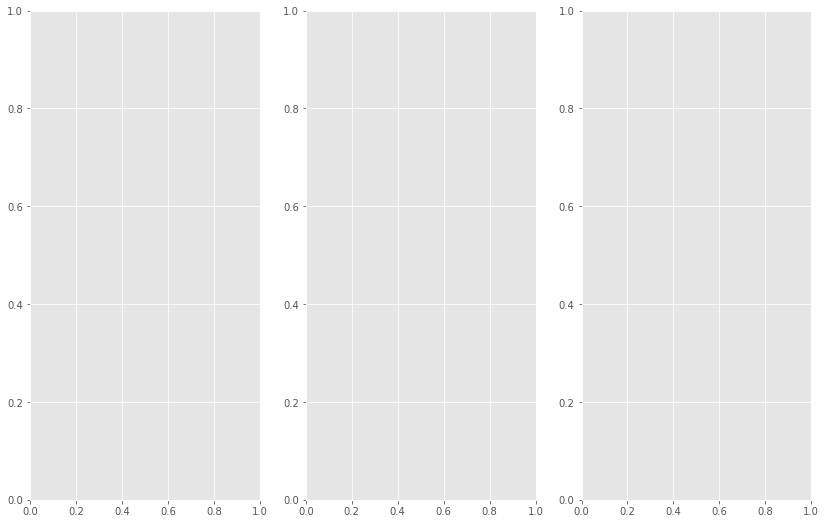

In [94]:
nbcol = 3
fig, ax = plt.subplots(ncols=nbcol, nrows=np.ceil(float(len(data_1))/nbcol).astype(np.int))
fig.set_size_inches(14, 3 * ax.shape[0])
ax = ax.reshape(-1)

for i in range(len(data_1)):
    yaw0 = data_1[i][0,2]
    A0 = np.array([[np.cos(yaw0),-np.sin(yaw0),0],[np.sin(yaw0),np.cos(yaw0),0],[0,0,1]])
    b0 = [data_1[i][0,0], data_1[i][0,1], data_1[i][0,2]]
    
    yawn = data_1[i][-1,2]
    An = np.array([[np.cos(yawn),-np.sin(yawn),0],[np.sin(yawn),np.cos(yawn),0],[0,0,1]])
    bn = [data_1[1][-1,0], data_1[1][-1,1], data_1[1][-1,2]]
    
    _mod1 = model.marginal_model(slice(0, 3)).lintrans(A0, b0)
    _mod2 = model.marginal_model(slice(3, 6)).lintrans(An, bn)
    
    # product 
    _prod = _mod1 * _mod2
    
    # get the most probable sequence of state for this demonstration
    sq = model.viterbi(demos[i])
    
    # solving LQR with Product of Gaussian, see notebook on LQR
    lqr = pbd.LQR(A, b, dt=0.0083, horizon=data_1[0].shape[0])
    lqr.gmm_xi = _prod, sq
    lqr.gmm_u = -4.
    lqr.ricatti()
    
    pos = data_1[i][0]
    vel = np.array([0,0,0])
    test = np.hstack([pos, vel])
    #lqr.x0 = test
    
    #xi = lqr.seq_xi
    xi, _ = lqr.get_seq(pos)
    ax[i].plot(xi[:, 0], xi[:, 1], color='r', lw=2)
        
    pbd.plot_gmm(_mod1.mu, _mod1.sigma, swap=True, ax=ax[i], dim=[0, 1], color='steelblue', alpha=0.3)
    pbd.plot_gmm(_mod2.mu, _mod2.sigma, swap=True, ax=ax[i], dim=[0, 1], color='orangered', alpha=0.3)
    
    pbd.plot_gmm(_prod.mu, _prod.sigma, swap=True, ax=ax[i], dim=[0, 1], color='gold', alpha=0.3)
        
    ax[i].plot(data_1[i][:, 0], data_1[i][:, 1], 'k--', lw=2)

plt.tight_layout()

In [ ]:
data_1[0][0]

In [ ]:
lqr.mvn_xi_dim

In [ ]:
data_1[i].shape[0]